# Data Preparation

<b> Import packages

In [124]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import copy

<b> Read file and data table

In [125]:
data_dir='/Users/christina/Desktop/Data Career/E-Commerce_DS/market_insights'

In [126]:
#csv
online_sales= pd.read_csv(os.path.join(data_dir, 'Online_Sales.csv'))
discount_coupon= pd.read_csv(os.path.join(data_dir, 'Discount_Coupon.csv'))
marketing_spent= pd.read_csv(os.path.join(data_dir, 'Marketing_Spend.csv'))

#xlsx
tax=pd.read_excel(os.path.join(data_dir, 'Tax_amount.xlsx'))
customer_demo=pd.read_excel(os.path.join(data_dir,'CustomersData.xlsx'))

In [127]:
month_mapping_dict={
    1: 'Jan', 2: 'Feb', 3:'Mar', 4: 'Apr', 5:'May', 6:'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

In [128]:
online_sales['Transaction_Date']=pd.to_datetime(online_sales['Transaction_Date'], format='%m/%d/%Y')
online_sales['Month']= online_sales['Transaction_Date'].dt.month.map(month_mapping_dict)

<b> Summary Table Preparation- Merging

In [129]:
#merging, tax, price and discount information 
discount_and_price_table=pd.merge(online_sales, discount_coupon, on=['Product_Category','Month'], how='left')
discount_and_price_tax_table=pd.merge(discount_and_price_table, tax, on='Product_Category', how='left')
#merge with customer demographic and tenure information
all_customer_discount_and_price_tax_table= pd.merge(customer_demo, discount_and_price_tax_table, on=['CustomerID'], how='left')

<b> Invoice Calulation

Calculate Invoice amount or sale_amount or revenue for each transaction and item level: <br> Invoice Value =(( QuantityAvg_price)(1-Dicount_pct)*(1+GST))+Delivery_Charges

In [7]:
all_customer_discount_and_price_tax_table['Coupon_Status'].value_counts()

Clicked     26926
Used        17904
Not Used     8094
Name: Coupon_Status, dtype: int64

In [8]:
#to reduce computational load, if cust didn't used coupon, change discount_pct to 0
all_customer_discount_and_price_tax_table['Discount_pct'] = all_customer_discount_and_price_tax_table.apply(
    lambda row: 0 if row['Coupon_Status'] != 'Used' else row['Discount_pct'], axis=1)
all_customer_discount_and_price_tax_table['Discount_pct'].fillna(0, inplace=True)

In [9]:
all_customer_discount_and_price_tax_table.head()

,CustomerID,Gender,Location,Tenure_Months,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Coupon_Code,Discount_pct,GST
0,17850,M,Chicago,12,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Jan,ELEC10,10.0,0.10
1,17850,M,Chicago,12,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Jan,ELEC10,10.0,0.10
2,17850,M,Chicago,12,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,Jan,OFF10,10.0,0.10
3,17850,M,Chicago,12,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used,Jan,SALE10,0.0,0.18
4,17850,M,Chicago,12,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,Jan,AIO10,10.0,0.18


In [10]:
#calculate Invoice Value with provided formula: (( Quantity* Avg_price)(1-Dicount_pct)*(1+GST))+Delivery_Charges
all_customer_discount_and_price_tax_table['Invoice_Value'] = all_customer_discount_and_price_tax_table.apply(
    lambda row: row['Quantity'] * row['Avg_Price']* (1 - row['Discount_pct']/100)* (1+row['GST']) + row['Delivery_Charges'], axis=1)

In [11]:
all_customer_discount_and_price_tax_table.head()

,CustomerID,Gender,Location,Tenure_Months,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Coupon_Code,Discount_pct,GST,Invoice_Value
0,17850,M,Chicago,12,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Jan,ELEC10,10.0,0.10,158.6729
1,17850,M,Chicago,12,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Jan,ELEC10,10.0,0.10,158.6729
2,17850,M,Chicago,12,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,Jan,OFF10,10.0,0.10,8.5295
3,17850,M,Chicago,12,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used,Jan,SALE10,0.0,0.18,109.9270
4,17850,M,Chicago,12,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,Jan,AIO10,10.0,0.18,24.0230


# Exploratory Analysis

1. how many customers acquired each month? 
2. Retention of customers on month basis
3. revenue from existing and new customers on month basis
4. how does the discount play as a role in revenue?
5. KPIs (revenue, number of orders, average order value, number of customers, quantity) by category, by month, by week, etc
6. trends/seasonality of sales by categroy, location, month, etc
7. how many order varies and sales with different days?
8. calculate the revenue, marketing spend, percentage of marketing spend out of revenue, tax, pct delivery charges by month (CAC)
9. How marketing spend is impacting on revenue?
10. Which product was appeared in the transactions?
11. Which product was purchased mostly based on the quantity?

## how many customers acquired each month? 

In [14]:
distinct_cust_table=copy.deepcopy(all_customer_discount_and_price_tax_table)
#amount of total purchase each month
purchase_count_by_month= distinct_cust_table.groupby('Month')['CustomerID'].count()
#amount of active customer (who bought at least once) each month
actcustomer_count_by_month=distinct_cust_table.groupby('Month')['CustomerID'].nunique()

In [15]:
months_df = pd.DataFrame({'Month': pd.date_range(start='2019-01-01', end='2019-12-01', freq='MS').strftime('%b')})
actcustomer_count_by_month_df= pd.merge(months_df, actcustomer_count_by_month.reset_index(name='new_customers'),
                                       on='Month', how='left')
actcustomer_count_by_month_df['new_customers'].fillna(0, inplace=True)

<Figure size 864x432 with 0 Axes>

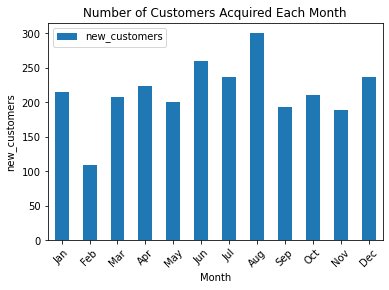

In [16]:
# Plot the bar plot- monthly active customer
plt.figure(figsize=(12,6))
actcustomer_count_by_month_df.plot(x='Month', y='new_customers', kind='bar')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('new_customers')
plt.xticks(rotation=45)
plt.title('Number of Customers Acquired Each Month')
plt.show()

## Monthly Rentention (MRR)-Retention of customers on month basis

In [17]:
Month_shortform_categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec']
actcustomer_count_by_month=actcustomer_count_by_month.reindex(Month_shortform_categories, axis=0)

In [18]:
#get monthly unique customer list
monthly_unique_customerID_list=distinct_cust_table.groupby('Month')['CustomerID'].unique().to_list()

#get retent customer list, and find duplicated counts
retention_customer_counts=[]
for month in range(len(Month_shortform_categories)):
    if month<1:
        retention_customer_count=0
        
    else: 
        previous_month_set= set(monthly_unique_customerID_list[month-1])
        current_month_set=set(monthly_unique_customerID_list[month])
        retention_customer_list= previous_month_set.intersection(current_month_set)
        retention_customer_count=len(retention_customer_list)
    retention_customer_counts.append(retention_customer_count)

In [19]:
retention_table=pd.DataFrame({'Month': Month_shortform_categories,
                'Retention_Cust': retention_customer_counts,
                'Total_Cust': actcustomer_count_by_month.values})

In [20]:
retention_table=pd.DataFrame({'Month': Month_shortform_categories,
                'Retention_Cust': retention_customer_counts,
                'Total_Cust': actcustomer_count_by_month.values})
retention_table['MRR (%)']=(retention_table['Retention_Cust']/retention_table['Total_Cust']*100).round(2)

In [21]:
#retention_table

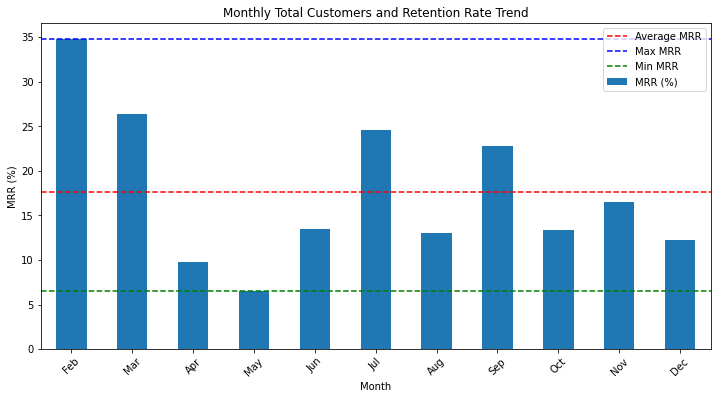

In [22]:
# Filter out the data for January, because retention=0 
retention_table_filtered = retention_table[retention_table['Month'] != 'Jan']

# Plotting for MRR and average MRR
ax= retention_table_filtered.plot(x='Month', y='MRR (%)', kind='bar')
average_mrr = retention_table_filtered['MRR (%)'].mean()
max_mrr = retention_table_filtered['MRR (%)'].max()
min_mrr = retention_table_filtered['MRR (%)'].min()
plt.axhline(y=average_mrr, color='red', linestyle='--', label='Average MRR')
plt.axhline(y=max_mrr, color='blue', linestyle='--', label='Max MRR')
plt.axhline(y=min_mrr, color='green', linestyle='--', label='Min MRR')



# Add labels and title
plt.xlabel('Month')
plt.ylabel('MRR (%)')
plt.title('Monthly Total Customers and Retention Rate Trend')

# Show legend
plt.legend()
plt.gcf().set_size_inches(12, 6)

# Show plot
plt.xticks(rotation=45)
plt.show()

## revenue from existing and new customers on month basis

In [14]:
all_customer_discount_and_price_tax_table['Revenue']= all_customer_discount_and_price_tax_table['Quantity']* all_customer_discount_and_price_tax_table['Avg_Price']* (100- all_customer_discount_and_price_tax_table['Discount_pct'])/100

In [24]:
old_revenue=[]
new_revenue=[]
old_CPI=[]
new_CPI=[]

accumulate_list=[]
for ind, month in enumerate(Month_shortform_categories):
    accumulate_list=Month_shortform_categories[:ind]

    # get previous months' all customerID
    all_old_month_transaction= all_customer_discount_and_price_tax_table[
        all_customer_discount_and_price_tax_table['Month'].isin(accumulate_list)]['CustomerID'].unique().tolist() #old
    # get this months' customerID
    new_month_transaction= all_customer_discount_and_price_tax_table[
        all_customer_discount_and_price_tax_table['Month']==month]['CustomerID'].unique().tolist()

    old_set= set(all_old_month_transaction)
    new_plus_old_set= set(new_month_transaction)

    #get old and new customerID for the month
    old_customers= new_plus_old_set.intersection(old_set)
    n_old_customers= len(old_customers)
    new_customers= new_plus_old_set-old_customers
    n_new_customers= len(new_customers)
    
    #calculate revenue and purchase power indicator (CPI) for old and new customerID 
    new_customer_revenue= all_customer_discount_and_price_tax_table[
        (all_customer_discount_and_price_tax_table['CustomerID'].isin(new_customers)) &
        (all_customer_discount_and_price_tax_table['Month'] == month)]['Revenue'].sum()
    new_customer_CPI= new_customer_revenue/n_new_customers

    old_customer_revenue= all_customer_discount_and_price_tax_table[
        (all_customer_discount_and_price_tax_table['CustomerID'].isin(old_customers)) &
        (all_customer_discount_and_price_tax_table['Month'] == month)]['Revenue'].sum()
    old_customer_CPI= old_customer_revenue/n_old_customers

    old_revenue.append(old_customer_revenue)
    new_revenue.append(new_customer_revenue)
    old_CPI.append(old_customer_CPI)
    new_CPI.append(new_customer_CPI)


<ipython-input-24-cf132bf22129>:35: RuntimeWarning: invalid value encountered in double_scalars
  old_customer_CPI= old_customer_revenue/n_old_customers


In [25]:
old_new_customer_revenue_CPI_df=pd.DataFrame(
    {"Month": Month_shortform_categories,
    "old_customer_revenue": old_revenue,
    "new_customer_revenue": new_revenue,
    "old_customer_CPI": old_CPI,
    "new_customer_CPI": new_CPI})
old_new_customer_revenue_CPI_df.fillna(0)

,Month,old_customer_revenue,new_customer_revenue,old_customer_CPI,new_customer_CPI
0,Jan,0.000,390151.310,0.000000,1814.657256
1,Feb,36313.494,254593.492,2793.345692,2652.015542
2,Mar,48053.172,265314.094,1550.102323,1498.949684
3,Apr,162412.416,223949.711,2662.498623,1373.924607
4,May,103661.206,184281.168,1177.968250,1645.367571
5,Jun,114164.125,174352.210,935.771516,1272.643869
6,Jul,215296.863,144274.533,1516.175092,1534.835457
7,Aug,194075.566,178456.928,1176.215552,1321.903170
8,Sep,190496.194,129935.406,1656.488643,1665.838538
9,Oct,185907.105,210082.250,1511.439878,2414.738506


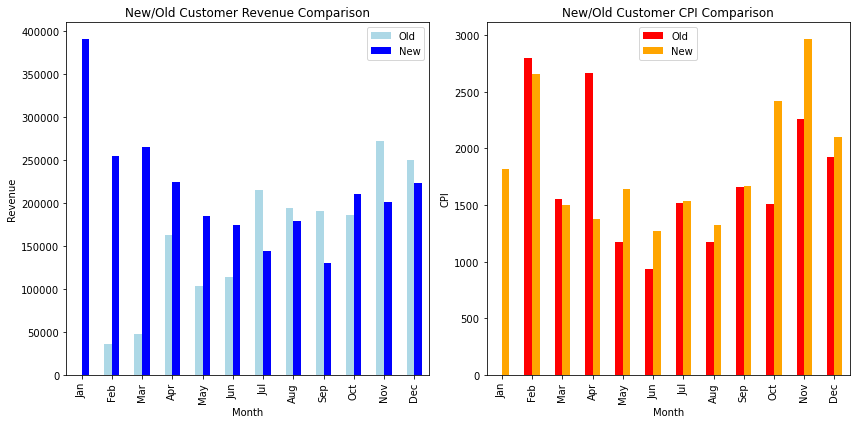

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the first bar plot on the first subplot
old_new_customer_revenue_CPI_df.plot(x='Month', 
                                     y=['old_customer_revenue','new_customer_revenue'], 
                                     kind='bar', ax=axes[0],
                                     color=['lightblue', 'blue'])
axes[0].set_title('New/Old Customer Revenue Comparison')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Revenue')
axes[0].legend(['Old', 'New'])

# Plot the second bar plot on the second subplot
old_new_customer_revenue_CPI_df.plot(x='Month', 
                                     y=['old_customer_CPI','new_customer_CPI'], 
                                     kind='bar', ax=axes[1],
                                     color=['red', 'orange'])
axes[1].set_title('New/Old Customer CPI Comparison')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('CPI')
axes[1].legend(['Old', 'New'])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

## how does the discount play as a role in revenue?

In [30]:
discount_and_revenue_df =all_customer_discount_and_price_tax_table[
    ['CustomerID', 'Gender', 'Location', 'Tenure_Months', 'Month', 'Product_Category', 'Quantity', 'Avg_Price', 'Coupon_Status', 'Discount_pct', 'Revenue']
]

### (A) Purchase and Revenue composition in different Coupon usage 

In [87]:
import matplotlib.colors as mcolors
css_colors = list(mcolors.CSS4_COLORS.keys())
#css_colors

details about the color code, see: https://matplotlib.org/stable/gallery/color/named_colors.html (CSS Colors section)

In [61]:
css_colors.index('lightsalmon')

75

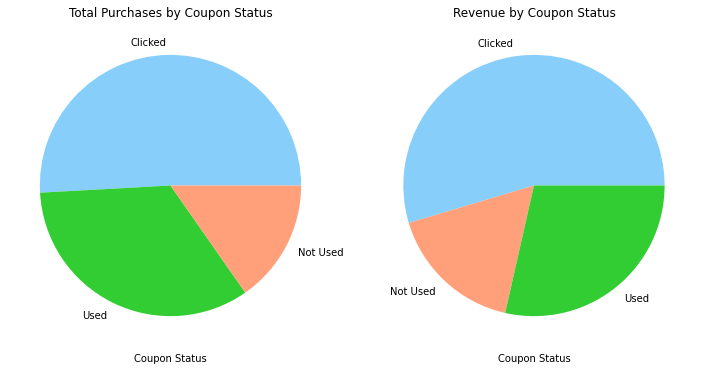

In [62]:
#Define Fixed colors for charts
colors = {'Clicked': css_colors[77], 'Used': css_colors[83], 'Not Used': css_colors[75]}


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the pie chart for total purchases
coupon_in_total_purchase = discount_and_revenue_df['Coupon_Status'].value_counts()
coupon_in_total_purchase.index = ['Clicked', 'Used', 'Not Used']
coupon_in_total_purchase.plot(kind='pie', colors=[colors.get(x, '#999999') for x in coupon_in_total_purchase.index], ax=axs[0])
axs[0].set_title('Total Purchases by Coupon Status')
axs[0].set_ylabel('')
axs[0].set_xlabel('Coupon Status')

# Plot the pie chart for revenue
revenue_by_coupon_status = discount_and_revenue_df.groupby('Coupon_Status')['Revenue'].sum()
revenue_by_coupon_status.plot(kind='pie', colors=[colors.get(x, '#999999') for x in revenue_by_coupon_status.index], ax=axs[1])
axs[1].set_title('Revenue by Coupon Status')
axs[1].set_ylabel('')
axs[1].set_xlabel('Coupon Status')

# Plotting
plt.tight_layout()
plt.show()

### (B) Coupon 的使用與否是否有具產品類別上的差異

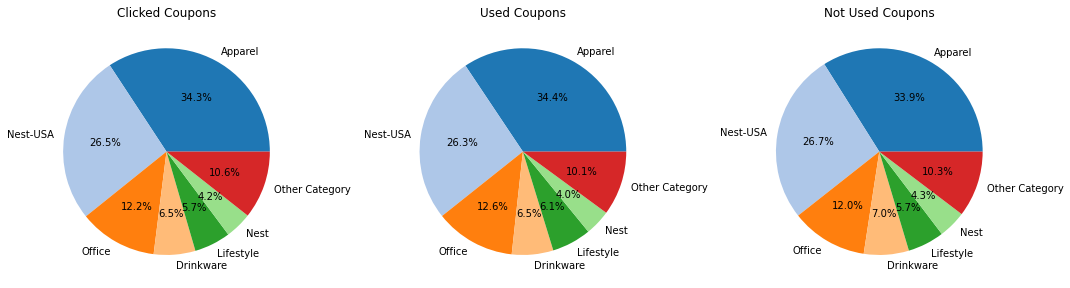

In [80]:
# if the category<0.04, shown & aggregate as OTHER
label_threshold = 0.04

#plot definition
colors = plt.cm.tab20.colors[:len(discount_and_revenue_df['Product_Category'].unique())]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot 3 pie
for i, coupon_status in enumerate(['Clicked', 'Used', 'Not Used']):
    # Filter the DataFrame for the current coupon status
    coupon_status_df = discount_and_revenue_df[discount_and_revenue_df['Coupon_Status'] == coupon_status]
    
    #counts for different category and filtered by threshold
    product_category_counts = coupon_status_df['Product_Category'].value_counts(normalize=True)
    other_category_percentage = product_category_counts[product_category_counts <= label_threshold].sum()
    product_category_counts = product_category_counts[product_category_counts > label_threshold]
    
    product_category_counts['Other Category'] = other_category_percentage
    
    # Plot the pie chart
    product_category_counts.plot(kind='pie', ax=axs[i], autopct='%1.1f%%', colors=colors)
    axs[i].set_title(f'{coupon_status} Coupons')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    
# Plotting
plt.tight_layout()
plt.show()

In [85]:
product_category_counts.index

Index(['F', 'M'], dtype='object')

In [90]:
css_colors[83]

'limegreen'

### (C) 在不同的 Coupon 使用情境下的性別分佈

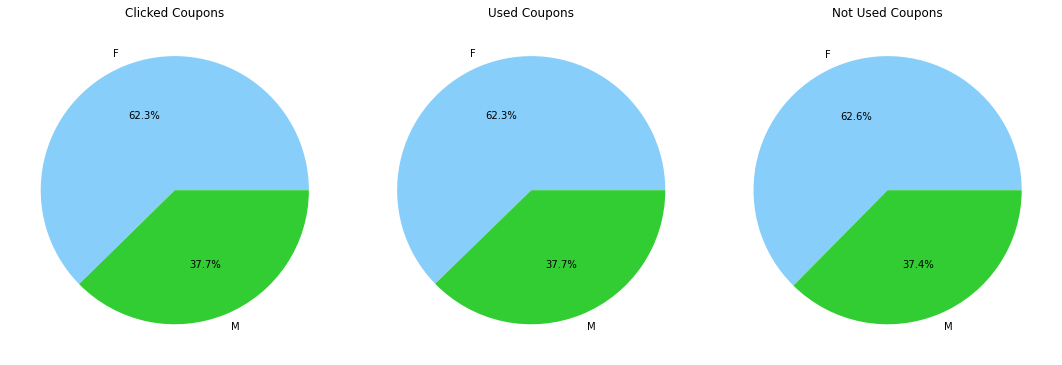

In [95]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot 3 pie charts
for i, coupon_status in enumerate(['Clicked', 'Used', 'Not Used']):
    # Filter the DataFrame for the current coupon status
    coupon_status_df = discount_and_revenue_df[discount_and_revenue_df['Coupon_Status'] == coupon_status]
    
    # Calculate counts for different categories and filter by threshold
    product_category_counts = coupon_status_df['Gender'].value_counts(normalize=True)
    
    # Plot the pie chart
    product_category_counts.plot(kind='pie', ax=axs[i], autopct='%1.1f%%', 
                                 colors=['lightskyblue', 'limegreen'])
    axs[i].set_title(f'{coupon_status} Coupons')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')

plt.tight_layout()
plt.show()

### (D) 在不同的 Coupon 使用情境下的顧客地理區分佈

/Users/christina/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


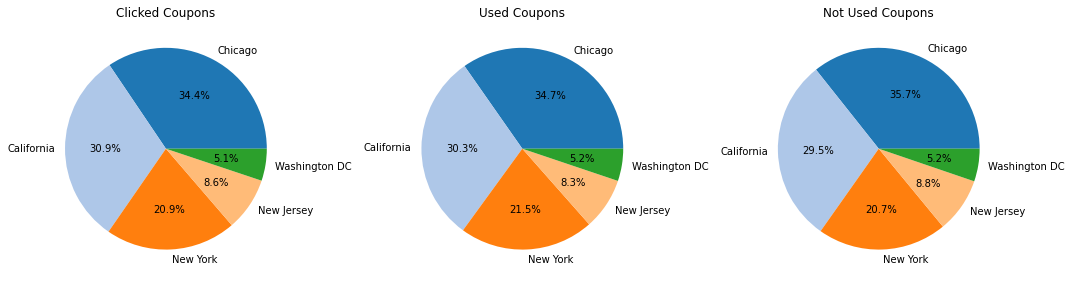

In [97]:
# if the category<0.04, shown & aggregate as OTHER
label_threshold = 0.04

#plot definition
colors = plt.cm.tab20.colors[:len(discount_and_revenue_df['Location'].unique())]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot 3 pie
for i, coupon_status in enumerate(['Clicked', 'Used', 'Not Used']):
    # Filter the DataFrame for the current coupon status
    coupon_status_df = discount_and_revenue_df[discount_and_revenue_df['Coupon_Status'] == coupon_status]
    
    #counts for different category and filtered by threshold
    product_category_counts = coupon_status_df['Location'].value_counts(normalize=True)
    other_category_percentage = product_category_counts[product_category_counts <= label_threshold].sum()
    product_category_counts = product_category_counts[product_category_counts > label_threshold]

    
    # Plot the pie chart
    product_category_counts.plot(kind='pie', ax=axs[i], autopct='%1.1f%%', colors=colors)
    axs[i].set_title(f'{coupon_status} Coupons')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    
# Plotting
plt.tight_layout()
plt.show()

### 【修改】(E) 在不同的 Coupon 使用情境下的顧客會員期分佈

In [106]:
#Define the intervals for categorization
bins = [0, 6, 12, 18, 24, 30, 36, 42, 48, float('inf')]  # The last bin includes values greater than 24
category_counts = pd.cut(discount_and_revenue_df['Tenure_Months'].unique(), 
                         bins=bins, 
                         labels=['<= 0.5 Year', '<= 1 Year', '<= 1.5 Year', '<= 2 Year', 
                                 '<= 2.5 Year', '<= 3 Year', '<= 3.5 Year', '<= 4 Year', '> 4 Year']).value_counts()


In [115]:
for i, coupon_status in enumerate(['Clicked', 'Used', 'Not Used']):
    # Filter the DataFrame for the current coupon status
    coupon_status_df = discount_and_revenue_df[discount_and_revenue_df['Coupon_Status'] == coupon_status]
    
    #counts for different category and filtered by threshold
    tenure_range_counts = pd.cut(coupon_status_df['Tenure_Months'].unique(), 
                         bins=bins, 
                         labels=['<= 0.5 Year', '<= 1 Year', '<= 1.5 Year', '<= 2 Year', 
                                 '<= 2.5 Year', '<= 3 Year', '<= 3.5 Year', '<= 4 Year', '> 4 Year']).value_counts()
    print(coupon_status, tenure_range_counts)

Clicked <= 0.5 Year    5
<= 1 Year      6
<= 1.5 Year    6
<= 2 Year      6
<= 2.5 Year    6
<= 3 Year      6
<= 3.5 Year    6
<= 4 Year      6
> 4 Year       2
dtype: int64
Used <= 0.5 Year    5
<= 1 Year      6
<= 1.5 Year    6
<= 2 Year      6
<= 2.5 Year    6
<= 3 Year      6
<= 3.5 Year    6
<= 4 Year      6
> 4 Year       2
dtype: int64
Not Used <= 0.5 Year    5
<= 1 Year      6
<= 1.5 Year    6
<= 2 Year      6
<= 2.5 Year    6
<= 3 Year      6
<= 3.5 Year    6
<= 4 Year      6
> 4 Year       2
dtype: int64


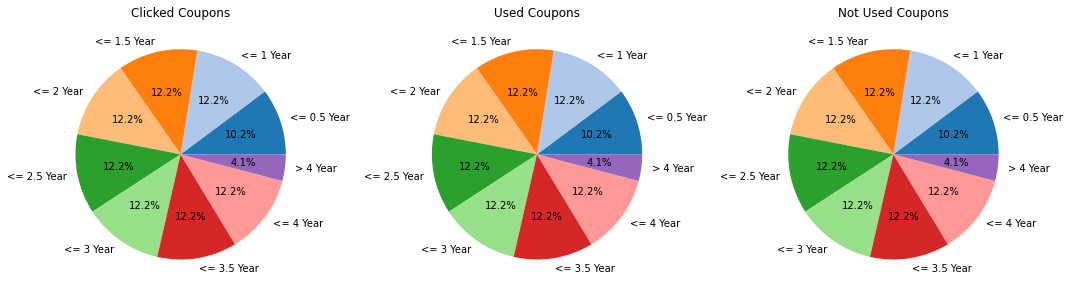

In [114]:
# if the category<0.04, shown & aggregate as OTHER
label_threshold = 0.04

#plot definition
bins = [0, 6, 12, 18, 24, 30, 36, 42, 48, float('inf')]  # The last bin includes values greater than 48


fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot 3 pie
for i, coupon_status in enumerate(['Clicked', 'Used', 'Not Used']):
    # Filter the DataFrame for the current coupon status
    coupon_status_df = discount_and_revenue_df[discount_and_revenue_df['Coupon_Status'] == coupon_status]
    
    #counts for different category and filtered by threshold
    tenure_range_counts = pd.cut(coupon_status_df['Tenure_Months'].unique(), 
                         bins=bins, 
                         labels=['<= 0.5 Year', '<= 1 Year', '<= 1.5 Year', '<= 2 Year', 
                                 '<= 2.5 Year', '<= 3 Year', '<= 3.5 Year', '<= 4 Year', '> 4 Year']).value_counts()
#     other_category_percentage = tenure_range_counts[tenure_range_counts <= label_threshold].sum()
#     tenure_range_counts = tenure_range_counts[tenure_range_counts > label_threshold]

    
    # Plot the pie chart
    colors = plt.cm.tab20.colors[:len(tenure_range_counts)]
    tenure_range_counts.plot(kind='pie', ax=axs[i], autopct='%1.1f%%', colors=colors)
    axs[i].set_title(f'{coupon_status} Coupons')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    
# Plotting
plt.tight_layout()
plt.show()

5. 用 Coupon 會讓新客變舊客嗎 (提高 Retention)

## KPIs (revenue, number of orders, average order value, number of customers, quantity) by category, by month, by week, etc

### Monthly KPIs

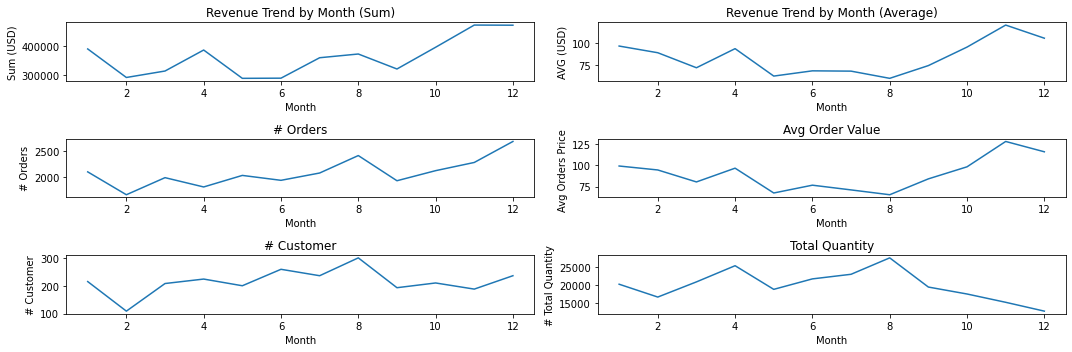

In [210]:
fig, axs = plt.subplots(3, 2, figsize=(15, 5))
#sum revenue 
month_timeseries_revenue_sum = round(month_timeseries_revenue_Df['sum_revenue'], 2)
month_timeseries_revenue_sum.plot(x='Month', y='Revenue', kind='line', ax=axs[0,0])
axs[0,0].set_title('Revenue Trend by Month (Sum)')
axs[0,0].set_xlabel('Month')
axs[0,0].set_ylabel('Sum (USD)')

# Avg revenue
month_timeseries_revenue_avg = round(month_timeseries_revenue_Df['avg_revenue'], 2)
month_timeseries_revenue_avg.plot(x='Month', y='Revenue', kind='line', ax=axs[0,1])
axs[0,1].set_title('Revenue Trend by Month (Average)')
axs[0,1].set_xlabel('Month')
axs[0,1].set_ylabel('AVG (USD)')

#axs[0,0].set_title('Revenue')

###
#number of orders
month_timeseries_norder_sum = round(month_timeseries_revenue_Df['n_orders'], 2)
month_timeseries_norder_sum.plot(x='Month', y='n_orders', kind='line', ax=axs[1,0])
axs[1,0].set_title('# Orders')
axs[1,0].set_xlabel('Month')
axs[1,0].set_ylabel('# Orders')

# Avg revenue
month_timeseries_orderprice_avg = round(month_timeseries_revenue_Df['avg_order_price'], 2)
month_timeseries_orderprice_avg.plot(x='Month', y='avg_order_price', kind='line', ax=axs[1,1])
axs[1,1].set_title('Avg Order Value')
axs[1,1].set_xlabel('Month')
axs[1,1].set_ylabel('Avg Orders Price ')

#axs[1,0].set_title('Order')
###
#number of orders
month_timeseries_ncustomer_sum = round(month_timeseries_revenue_Df['n_customers'], 2)
month_timeseries_ncustomer_sum.plot(x='Month', y='n_customers', kind='line', ax=axs[2,0])
axs[2,0].set_title('# Customer')
axs[2,0].set_xlabel('Month')
axs[2,0].set_ylabel('# Customer')

# Avg revenue
month_timeseries_quantity_avg = round(month_timeseries_revenue_Df['sum_quantity'], 2)
month_timeseries_quantity_avg.plot(x='Month', y='sum_quantity', kind='line', ax=axs[2,1])
axs[2,1].set_title('Total Quantity')
axs[2,1].set_xlabel('Month')
axs[2,1].set_ylabel('# Total Quantity')

plt.tight_layout()
plt.show()

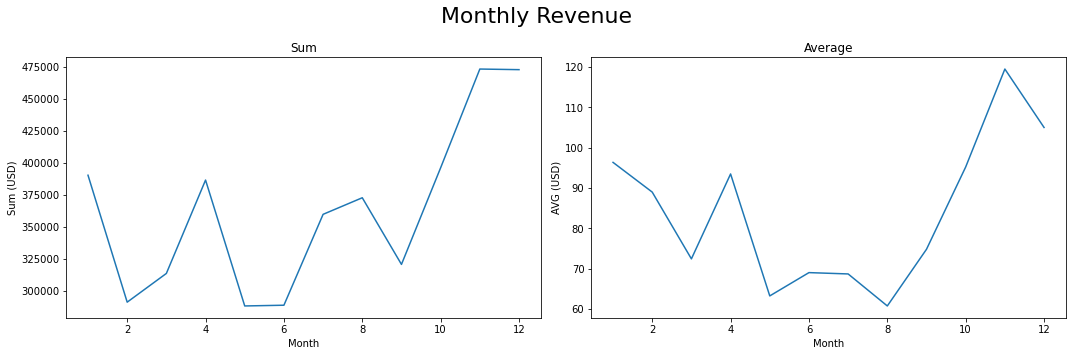

In [207]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#number of orders
month_timeseries_revenue_sum = round(month_timeseries_revenue_Df['sum_revenue'], 2)
month_timeseries_revenue_sum.plot(x='Month', y='Revenue', kind='line', ax=axs[0])
axs[0].set_title('Sum')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Sum (USD)')

# Avg revenue
month_timeseries_revenue_avg = round(month_timeseries_revenue_Df['avg_revenue'], 2)
month_timeseries_revenue_avg.plot(x='Month', y='Revenue', kind='line', ax=axs[1])
axs[1].set_title('Average')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('AVG (USD)')

fig.suptitle('Monthly Revenue', fontsize=22)
plt.tight_layout()
plt.show()

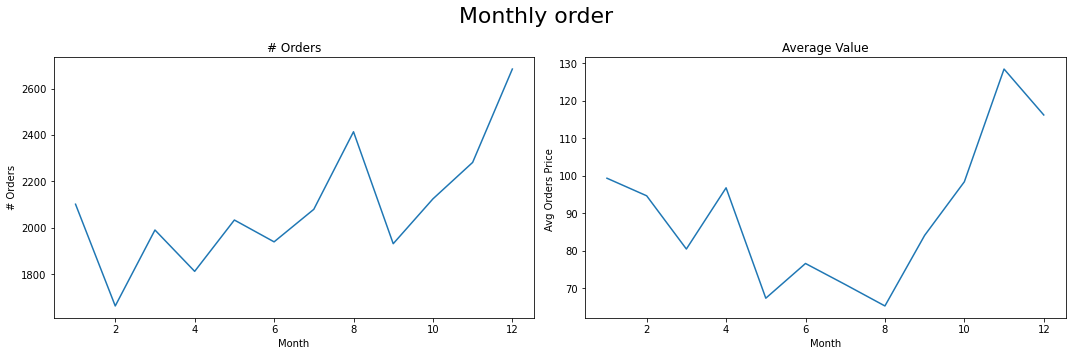

In [208]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#number of orders
month_timeseries_norder_sum = round(month_timeseries_revenue_Df['n_orders'], 2)
month_timeseries_norder_sum.plot(x='Month', y='n_orders', kind='line', ax=axs[0])
axs[0].set_title('# Orders')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('# Orders')

# Avg revenue
month_timeseries_orderprice_avg = round(month_timeseries_revenue_Df['avg_order_price'], 2)
month_timeseries_orderprice_avg.plot(x='Month', y='avg_order_price', kind='line', ax=axs[1])
axs[1].set_title('Average Value')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Avg Orders Price ')

fig.suptitle('Monthly order', fontsize=22)
plt.tight_layout()
plt.show()

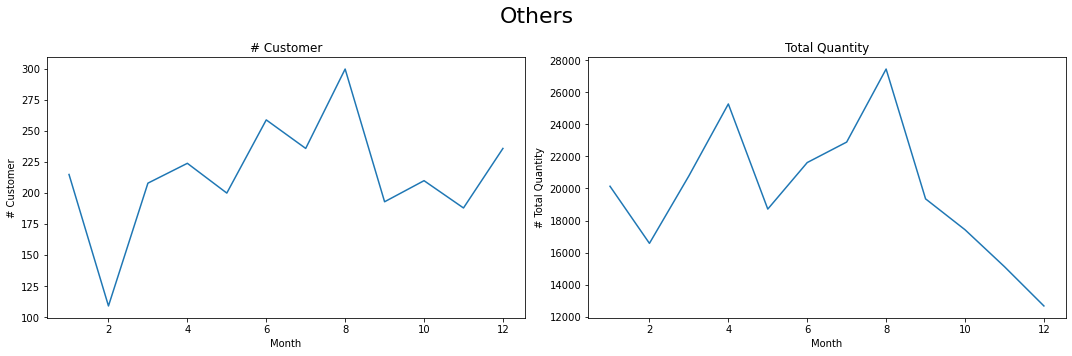

In [211]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# #Customers
month_timeseries_ncustomer_sum = round(month_timeseries_revenue_Df['n_customers'], 2)
month_timeseries_ncustomer_sum.plot(x='Month', y='n_customers', kind='line', ax=axs[0])
axs[0].set_title('# Customer')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('# Customer')

# Quantity
month_timeseries_quantity_avg = round(month_timeseries_revenue_Df['sum_quantity'], 2)
month_timeseries_quantity_avg.plot(x='Month', y='sum_quantity', kind='line', ax=axs[1])
axs[1].set_title('Total Quantity')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('# Total Quantity')

fig.suptitle('Others', fontsize=22)
plt.tight_layout()
plt.show()

### Weekly KPIs

In [214]:
week_timeseries_revenue_Df=pd.DataFrame(
    {"Week": sorted(all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U').unique()),
     "sum_revenue": all_customer_discount_and_price_tax_table.groupby(all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')).apply(lambda x: x['Revenue'].sum()),
     "avg_revenue": all_customer_discount_and_price_tax_table.groupby(all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')).apply(lambda x: x['Revenue'].mean()),
     "n_orders": all_customer_discount_and_price_tax_table.groupby(all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U'))['Transaction_ID'].nunique(),
     "avg_order_price": all_customer_discount_and_price_tax_table.groupby(all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')).apply(lambda x: (x['Quantity']*x['Avg_Price']).mean()),
     "n_customers": all_customer_discount_and_price_tax_table.groupby(all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U'))['CustomerID'].nunique(),
     "sum_quantity": all_customer_discount_and_price_tax_table.groupby(all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')).apply(lambda x: (x['Quantity']).sum()),
    })

<b> Summary Plot 

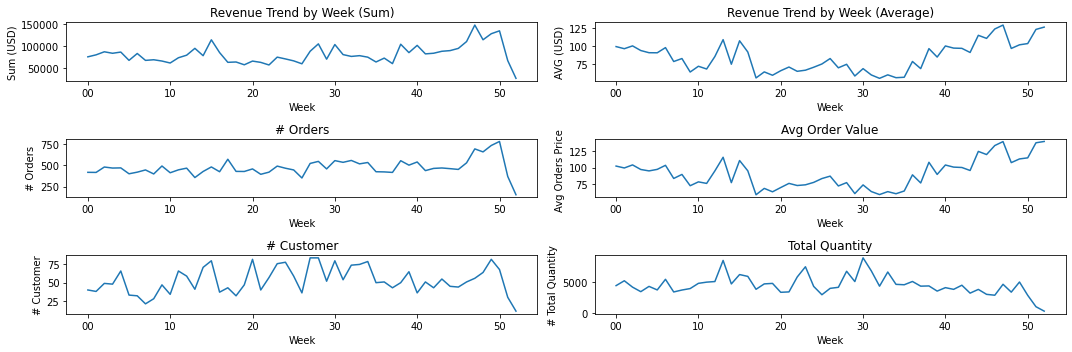

In [215]:
fig, axs = plt.subplots(3, 2, figsize=(15, 5))
#sum revenue 
week_timeseries_revenue_sum = round(week_timeseries_revenue_Df['sum_revenue'], 2)
week_timeseries_revenue_sum.plot(x='Week', y='Revenue', kind='line', ax=axs[0,0])
axs[0,0].set_title('Revenue Trend by Week (Sum)')
axs[0,0].set_xlabel('Week')
axs[0,0].set_ylabel('Sum (USD)')

# Avg revenue
week_timeseries_revenue_avg = round(week_timeseries_revenue_Df['avg_revenue'], 2)
week_timeseries_revenue_avg.plot(x='Week', y='Revenue', kind='line', ax=axs[0,1])
axs[0,1].set_title('Revenue Trend by Week (Average)')
axs[0,1].set_xlabel('Week')
axs[0,1].set_ylabel('AVG (USD)')

#axs[0,0].set_title('Revenue')

###
#number of orders
week_timeseries_norder_sum = round(week_timeseries_revenue_Df['n_orders'], 2)
week_timeseries_norder_sum.plot(x='Week', y='n_orders', kind='line', ax=axs[1,0])
axs[1,0].set_title('# Orders')
axs[1,0].set_xlabel('Week')
axs[1,0].set_ylabel('# Orders')

# Avg revenue
week_timeseries_orderprice_avg = round(week_timeseries_revenue_Df['avg_order_price'], 2)
week_timeseries_orderprice_avg.plot(x='Week', y='avg_order_price', kind='line', ax=axs[1,1])
axs[1,1].set_title('Avg Order Value')
axs[1,1].set_xlabel('Week')
axs[1,1].set_ylabel('Avg Orders Price ')

#axs[1,0].set_title('Order')
###
#number of orders
week_timeseries_ncustomer_sum = round(week_timeseries_revenue_Df['n_customers'], 2)
week_timeseries_ncustomer_sum.plot(x='Week', y='n_customers', kind='line', ax=axs[2,0])
axs[2,0].set_title('# Customer')
axs[2,0].set_xlabel('Week')
axs[2,0].set_ylabel('# Customer')

# Avg revenue
week_timeseries_quantity_avg = round(week_timeseries_revenue_Df['sum_quantity'], 2)
week_timeseries_quantity_avg.plot(x='Week', y='sum_quantity', kind='line', ax=axs[2,1])
axs[2,1].set_title('Total Quantity')
axs[2,1].set_xlabel('Week')
axs[2,1].set_ylabel('# Total Quantity')

plt.tight_layout()
plt.show()

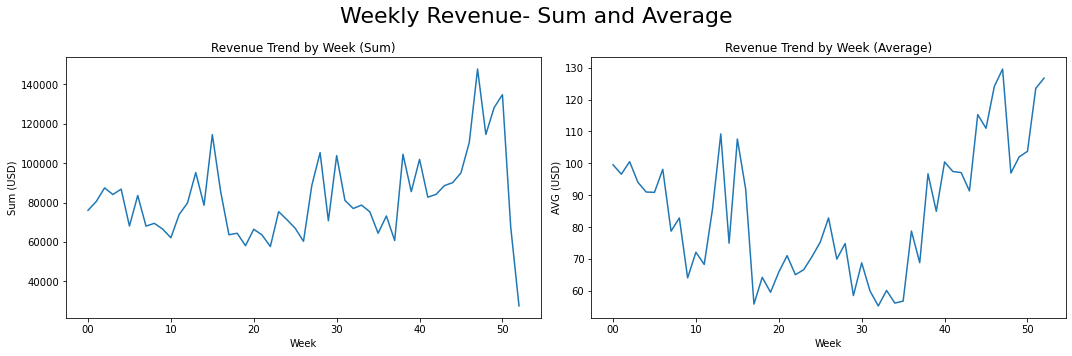

In [163]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Sum revenue
week_timeseries_revenue_sum = round(week_timeseries_revenue_Df.groupby('Week')['Revenue'].sum(), 2)
week_timeseries_revenue_sum.plot(x='Week', y='Revenue', kind='line', ax=axs[0])
axs[0].set_title('Revenue Trend by Week (Sum)')
axs[0].set_xlabel('Week')
axs[0].set_ylabel('Sum (USD)')

# Avg revenue
week_timeseries_revenue_sum = round(week_timeseries_revenue_Df.groupby('Week')['Revenue'].mean(), 2)
week_timeseries_revenue_sum.plot(x='Week', y='Revenue', kind='line', ax=axs[1])
axs[1].set_title('Revenue Trend by Week (Average)')
axs[1].set_xlabel('Week')
axs[1].set_ylabel('AVG (USD)')

# Show the plot
fig.suptitle('Weekly Revenue- Sum and Average', fontsize=22)
plt.tight_layout()
plt.show()

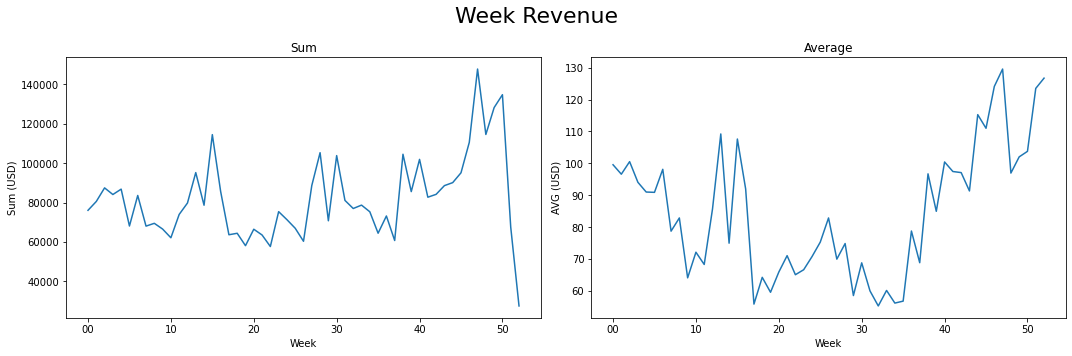

In [216]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#number of orders
week_timeseries_revenue_sum = round(week_timeseries_revenue_Df['sum_revenue'], 2)
week_timeseries_revenue_sum.plot(x='Week', y='Revenue', kind='line', ax=axs[0])
axs[0].set_title('Sum')
axs[0].set_xlabel('Week')
axs[0].set_ylabel('Sum (USD)')

# Avg revenue
week_timeseries_revenue_avg = round(week_timeseries_revenue_Df['avg_revenue'], 2)
week_timeseries_revenue_avg.plot(x='Week', y='Revenue', kind='line', ax=axs[1])
axs[1].set_title('Average')
axs[1].set_xlabel('Week')
axs[1].set_ylabel('AVG (USD)')

fig.suptitle('Week Revenue', fontsize=22)
plt.tight_layout()
plt.show()

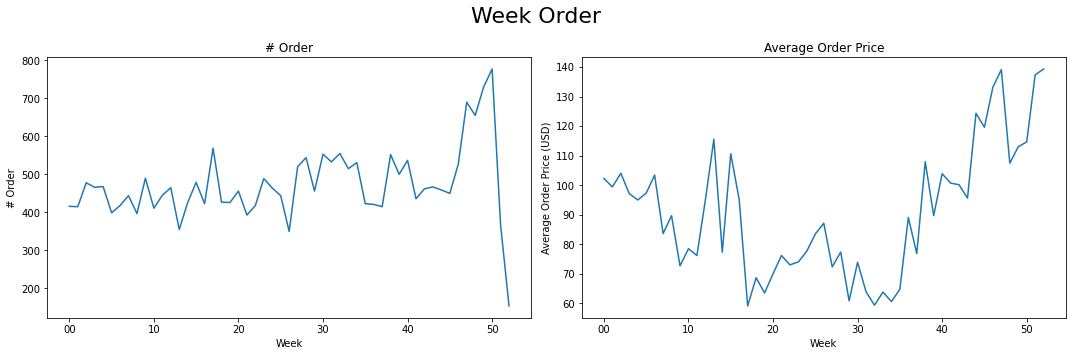

In [218]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#number of orders
week_timeseries_norder_sum = round(week_timeseries_revenue_Df['n_orders'], 2)
week_timeseries_norder_sum.plot(x='Week', y='n_orders', kind='line', ax=axs[0])
axs[0].set_title('# Order')
axs[0].set_xlabel('Week')
axs[0].set_ylabel('# Order')

# Avg revenue
week_timeseries_orderprice_avg = round(week_timeseries_revenue_Df['avg_order_price'], 2)
week_timeseries_orderprice_avg.plot(x='Week', y='avg_order_price', kind='line', ax=axs[1])
axs[1].set_title('Average Order Price')
axs[1].set_xlabel('Week')
axs[1].set_ylabel('Average Order Price (USD)')

fig.suptitle('Week Order', fontsize=22)
plt.tight_layout()
plt.show()

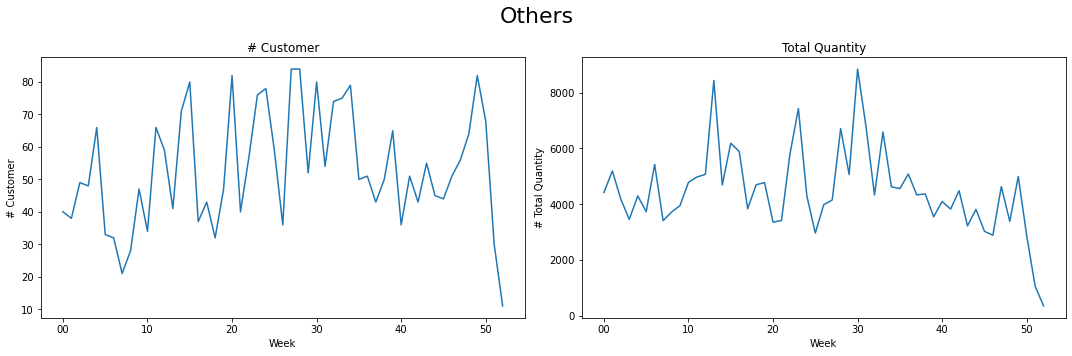

In [219]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# #Customers
week_timeseries_ncustomer_sum = round(week_timeseries_revenue_Df['n_customers'], 2)
week_timeseries_ncustomer_sum.plot(x='Week', y='n_customers', kind='line', ax=axs[0])
axs[0].set_title('# Customer')
axs[0].set_xlabel('Week')
axs[0].set_ylabel('# Customer')

# Quantity
week_timeseries_quantity_avg = round(week_timeseries_revenue_Df['sum_quantity'], 2)
week_timeseries_quantity_avg.plot(x='Week', y='sum_quantity', kind='line', ax=axs[1])
axs[1].set_title('Total Quantity')
axs[1].set_xlabel('Week')
axs[1].set_ylabel('# Total Quantity')

fig.suptitle('Others', fontsize=22)
plt.tight_layout()
plt.show()

### Categories and Time

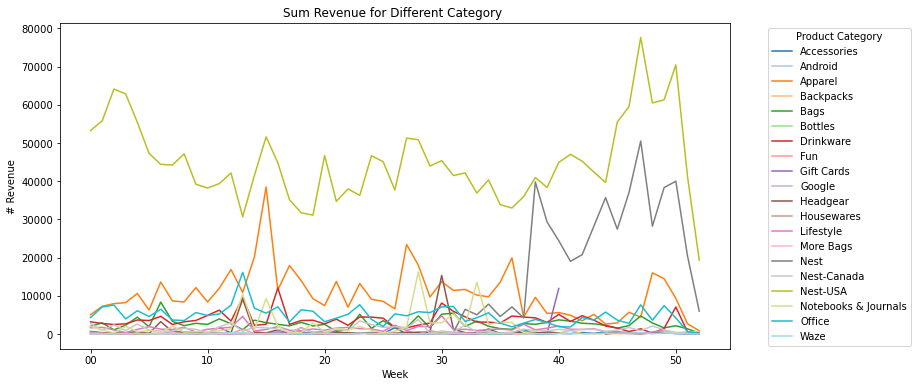

In [240]:
colors = plt.cm.tab20.colors[:len(all_customer_discount_and_price_tax_table['Product_Category'].unique())]
all_customer_discount_and_price_tax_table['Week'] = all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')
#revenue_by_week_category = transaction_table.groupby(['Week', 'Product_Category'])['Revenue'].sum().unstack()
sum_revenue_by_week_category = all_customer_discount_and_price_tax_table.groupby(['Week', 'Product_Category'])['Revenue'].sum().unstack()
sum_revenue_by_week_category.fillna(0)
sum_revenue_by_week_category.plot(kind='line', figsize=(12, 6), color=colors)
plt.title('Sum Revenue for Different Category ')
plt.xlabel('Week')
plt.ylabel('# Revenue')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')

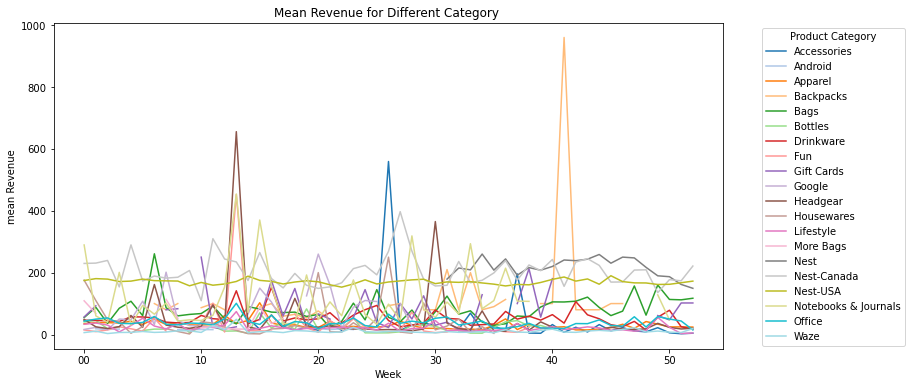

In [242]:
colors = plt.cm.tab20.colors[:len(all_customer_discount_and_price_tax_table['Product_Category'].unique())]
all_customer_discount_and_price_tax_table['Week'] = all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')
#revenue_by_week_category = transaction_table.groupby(['Week', 'Product_Category'])['Revenue'].sum().unstack()
sum_revenue_by_week_category = all_customer_discount_and_price_tax_table.groupby(['Week', 'Product_Category'])['Revenue'].mean().unstack()
sum_revenue_by_week_category.fillna(0)
sum_revenue_by_week_category.plot(kind='line', figsize=(12, 6), color=colors)
plt.title('Mean Revenue for Different Category ')
plt.xlabel('Week')
plt.ylabel('mean Revenue')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')

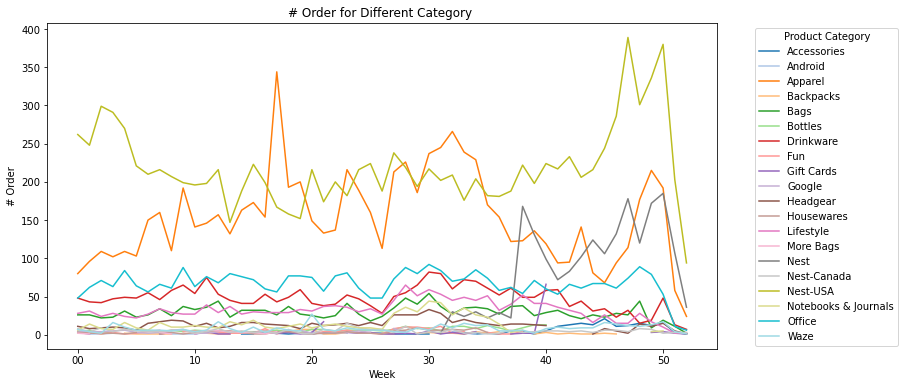

In [243]:
colors = plt.cm.tab20.colors[:len(all_customer_discount_and_price_tax_table['Product_Category'].unique())]
all_customer_discount_and_price_tax_table['Week'] = all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')
#revenue_by_week_category = transaction_table.groupby(['Week', 'Product_Category'])['Revenue'].sum().unstack()
sum_revenue_by_week_category = all_customer_discount_and_price_tax_table.groupby(['Week', 'Product_Category'])['Transaction_ID'].nunique().unstack()
sum_revenue_by_week_category.fillna(0)
sum_revenue_by_week_category.plot(kind='line', figsize=(12, 6), color=colors)
plt.title('# Order for Different Category ')
plt.xlabel('Week')
plt.ylabel('# Order')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')

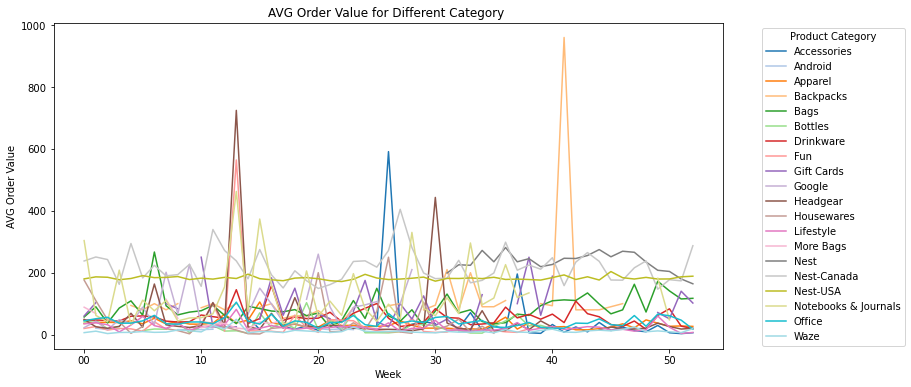

In [249]:
colors = plt.cm.tab20.colors[:len(all_customer_discount_and_price_tax_table['Product_Category'].unique())]
all_customer_discount_and_price_tax_table['Week'] = all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')
#revenue_by_week_category = transaction_table.groupby(['Week', 'Product_Category'])['Revenue'].sum().unstack()
indicator = all_customer_discount_and_price_tax_table.groupby(['Week', 'Product_Category']).apply(lambda x: (x['Quantity']*x['Avg_Price']).mean()).unstack()
indicator.fillna(0)
indicator.plot(kind='line', figsize=(12, 6), color=colors)
plt.title('AVG Order Value for Different Category ')
plt.xlabel('Week')
plt.ylabel('AVG Order Value')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')

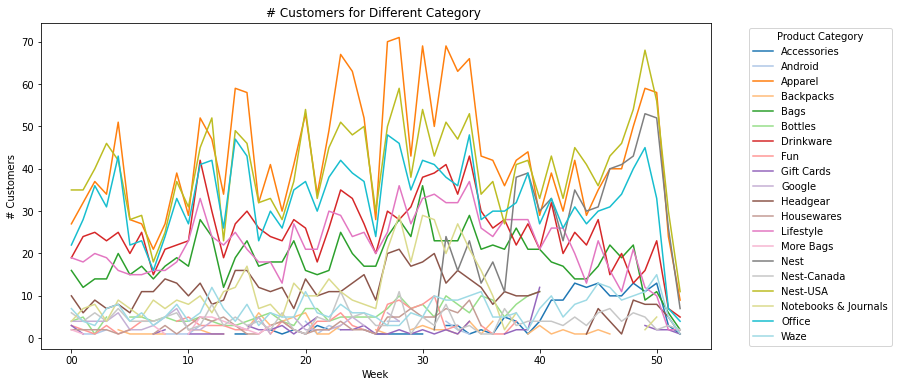

In [251]:
colors = plt.cm.tab20.colors[:len(all_customer_discount_and_price_tax_table['Product_Category'].unique())]
all_customer_discount_and_price_tax_table['Week'] = all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')
#revenue_by_week_category = transaction_table.groupby(['Week', 'Product_Category'])['Revenue'].sum().unstack()
indicator = all_customer_discount_and_price_tax_table.groupby(['Week', 'Product_Category'])['CustomerID'].nunique().unstack()
indicator.fillna(0)
indicator.plot(kind='line', figsize=(12, 6), color=colors)
plt.title('# Customers for Different Category ')
plt.xlabel('Week')
plt.ylabel('# Customers')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')

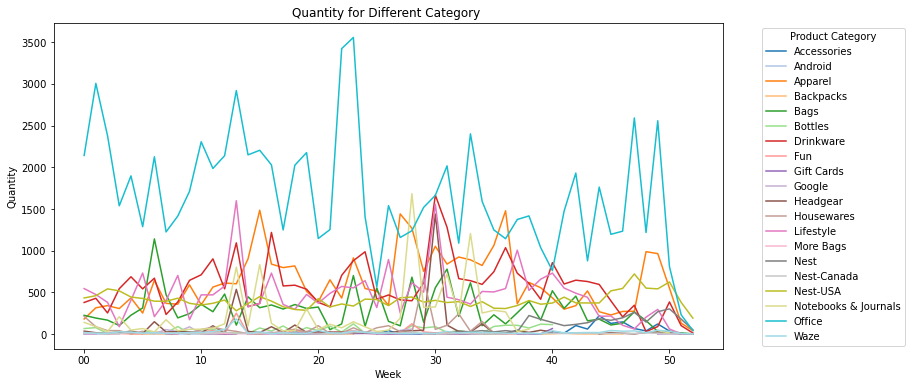

In [252]:
colors = plt.cm.tab20.colors[:len(all_customer_discount_and_price_tax_table['Product_Category'].unique())]
all_customer_discount_and_price_tax_table['Week'] = all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')
#revenue_by_week_category = transaction_table.groupby(['Week', 'Product_Category'])['Revenue'].sum().unstack()
indicator = all_customer_discount_and_price_tax_table.groupby(['Week', 'Product_Category']).apply(lambda x: (x['Quantity']).sum()).unstack()
indicator.fillna(0)
indicator.plot(kind='line', figsize=(12, 6), color=colors)
plt.title('Quantity for Different Category ')
plt.xlabel('Week')
plt.ylabel('Quantity')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')

## Trends/seasonality of sales (categroy, location, month)

In [254]:
from statsmodels.tsa.seasonal import seasonal_decompose

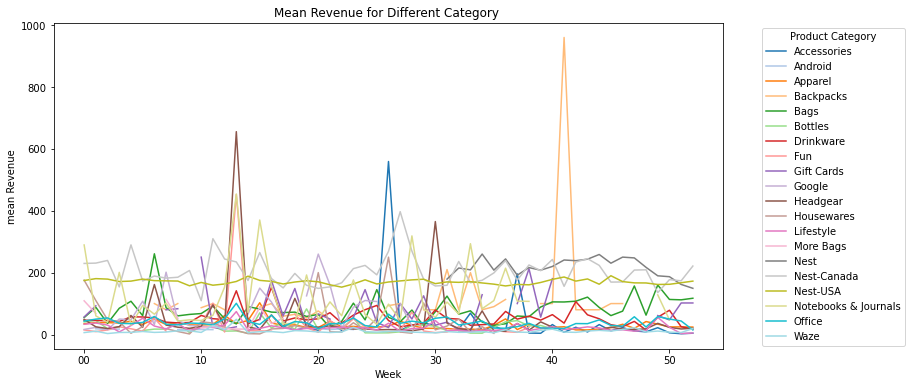

In [317]:
colors = plt.cm.tab20.colors[:len(all_customer_discount_and_price_tax_table['Product_Category'].unique())]
all_customer_discount_and_price_tax_table['Week'] = all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')
#revenue_by_week_category = transaction_table.groupby(['Week', 'Product_Category'])['Revenue'].sum().unstack()
sum_revenue_by_week_category = all_customer_discount_and_price_tax_table.groupby(['Week', 'Product_Category'])['Revenue'].mean().unstack()
sum_revenue_by_week_category.fillna(0)
sum_revenue_by_week_category.plot(kind='line', figsize=(12, 6), color=colors)
plt.title('Mean Revenue for Different Category ')
plt.xlabel('Week')
plt.ylabel('mean Revenue')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')

In [334]:
all_customer_discount_and_price_tax_table.columns

Index(['CustomerID', 'Gender', 'Location', 'Tenure_Months', 'Transaction_ID',
       'Transaction_Date', 'Product_SKU', 'Product_Description',
       'Product_Category', 'Quantity', 'Avg_Price', 'Delivery_Charges',
       'Coupon_Status', 'Month', 'Coupon_Code', 'Discount_pct', 'GST',
       'Invoice_Value', 'Revenue', 'Week'],
      dtype='object')

In [338]:
sum_revenue_by_day_category = all_customer_discount_and_price_tax_table.groupby(['Transaction_Date', 'Product_Category'])['Revenue'].sum().unstack()
sum_revenue_by_day_category=  sum_revenue_by_day_category.fillna(0)

In [337]:
sum_revenue_by_week_category = all_customer_discount_and_price_tax_table.groupby(['Week', 'Product_Category'])['Revenue'].sum().unstack()
sum_revenue_by_week_category = sum_revenue_by_week_category.fillna(0)

In [323]:
sum_revenue_by_week_category.columns

Index(['Accessories', 'Android', 'Apparel', 'Backpacks', 'Bags', 'Bottles',
       'Drinkware', 'Fun', 'Gift Cards', 'Google', 'Headgear', 'Housewares',
       'Lifestyle', 'More Bags', 'Nest', 'Nest-Canada', 'Nest-USA',
       'Notebooks & Journals', 'Office', 'Waze'],
      dtype='object', name='Product_Category')

In [373]:
import matplotlib.dates as mdates

In [389]:
# Trend Decomposition #2month- period 
topic= 'Notebooks & Journals'
test=sum_revenue_by_day_category[topic]
result = seasonal_decompose(test, model='additive', period=30)

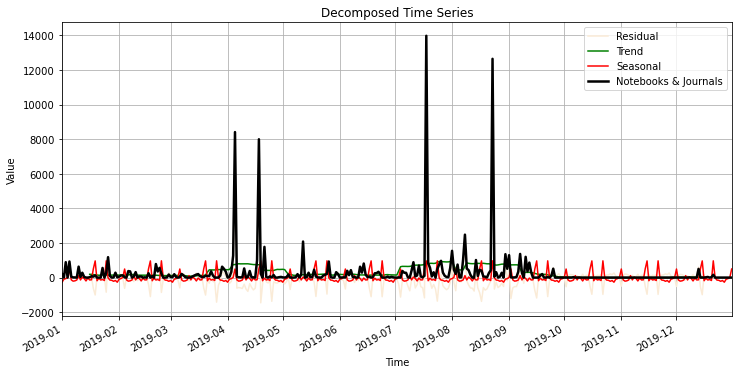

In [390]:
plt.figure(figsize=(20,5))
# Plot trend, seasonal, and residual components

plt.plot(result.resid, color='antiquewhite', label='Residual')
plt.plot(result.trend, color='green', label='Trend')
plt.plot(result.seasonal, color='red', label='Seasonal')
sum_revenue_by_day_category[topic].plot(kind='line', figsize=(12, 6), color='black', linewidth=2.5)

# Add vertical lines at the beginning of each month
locator = mdates.MonthLocator()  # Create a MonthLocator instance
formatter = mdates.DateFormatter('%Y-%m')  # Define the date format for the labels
plt.gca().xaxis.set_major_locator(locator)  # Set the major locator for the x-axis
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().grid(True)  # Show gridlines
plt.gca().autoscale(enable=True, axis='x', tight=True)  # Autoscale the x-axis
plt.gca().margins(x=0)  # Set margins to zero for tight layout

# Set plot labels and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Decomposed Time Series')
plt.legend()

# Show plot
plt.show()


<b> 7. how many order varies and sales with different days?

## calculate the revenue, marketing spend, percentage of marketing spend out of revenue, tax, pct delivery charges by month (CAC)

In [397]:
marketing_spent['Date']=pd.to_datetime(marketing_spent['Date'], format='%m/%d/%Y')

In [405]:
sf_df=all_customer_discount_and_price_tax_table[[
    'CustomerID','Transaction_ID','Transaction_Date','Revenue'
]]

In [410]:
all_customer_discount_and_price_tax_table.head()

,CustomerID,Gender,Location,Tenure_Months,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Coupon_Code,Discount_pct,GST,Invoice_Value,Revenue,Week
0,17850,M,Chicago,12,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Jan,ELEC10,10.0,0.10,158.6729,138.339,00
1,17850,M,Chicago,12,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,Jan,ELEC10,10.0,0.10,158.6729,138.339,00
2,17850,M,Chicago,12,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,Jan,OFF10,10.0,0.10,8.5295,1.845,00
3,17850,M,Chicago,12,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used,Jan,SALE10,0.0,0.18,109.9270,87.650,00
4,17850,M,Chicago,12,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,Jan,AIO10,10.0,0.18,24.0230,14.850,00


In [411]:
pct_marketing_revenue= pd.DataFrame({"Total_Revenue": sf_df.groupby(sf_df['Transaction_Date'].dt.month)['Revenue'].sum(),
"Marketing_Cost": marketing_spent.groupby(marketing_spent['Date'].dt.month)['Online_Spend'].sum()})
#Calculate the Revenue, Marketing spend, percentage of marketing spend out of revenue, Tax, percentage of delivery charges by month.

In [416]:
pct_marketing_revenue["Efficiency"]=pct_marketing_revenue["Total_Revenue"]/pct_marketing_revenue["Marketing_Cost"]

In [419]:
month_digit_list=[]
for i in range(1,13):
    month_digit_list.append(i)

In [420]:
pct_marketing_revenue["Month"]=month_digit_list

In [421]:
pct_marketing_revenue

,Total_Revenue,Marketing_Cost,Efficiency,Month
1,390151.310,58328.95,6.688811,1
2,290906.986,55807.92,5.212647,2
3,313367.266,48750.09,6.428035,3
4,386362.127,61026.83,6.331021,4
5,287942.374,52759.64,5.457626,5
6,288516.335,53818.14,5.360950,6
7,359571.396,52717.85,6.820676,7
8,372532.494,57404.15,6.489644,8
9,320431.600,52514.54,6.101769,9
10,395989.355,57724.65,6.859970,10


<AxesSubplot:xlabel='Month'>

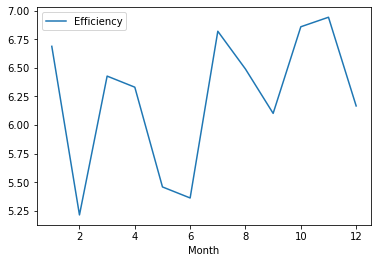

In [422]:
pct_marketing_revenue.plot(x="Month", y="Efficiency" , kind="line")

In [406]:
summary_df=pd.merge(sf_df,marketing_spent,
                    how='left',
                   left_on='Transaction_Date',
                   right_on='Date')

In [407]:
summary_df

,CustomerID,Transaction_ID,Transaction_Date,Revenue,Date,Offline_Spend,Online_Spend
0,17850,16679,2019-01-01,138.339,2019-01-01,4500,2424.50
1,17850,16680,2019-01-01,138.339,2019-01-01,4500,2424.50
2,17850,16681,2019-01-01,1.845,2019-01-01,4500,2424.50
3,17850,16682,2019-01-01,87.650,2019-01-01,4500,2424.50
4,17850,16682,2019-01-01,14.850,2019-01-01,4500,2424.50
...,...,...,...,...,...,...,...
52919,14410,48493,2019-12-31,121.300,2019-12-31,4000,2058.75
52920,14410,48494,2019-12-31,34.244,2019-12-31,4000,2058.75
52921,14410,48495,2019-12-31,106.316,2019-12-31,4000,2058.75
52922,14600,48496,2019-12-31,402.600,2019-12-31,4000,2058.75


<b> 9. How marketing spend is impacting on revenue?

<b> 10. Which product was appeared in the transactions?

<b> 11. Which product was purchased mostly based on the quantity?

# Customer Segregation

1. Heuristic (Value based, RFM) – Divide the customers into Premium, Gold, Silver,Standard customers <br> Define strategy on the same.
2. Scientific (Using K-Means) & Understand the profiles. <br> Define strategy for each segment.

## 【Strategy1】get the quantile of the total customer population

In [539]:
rmf_table=copy.deepcopy(all_customer_discount_and_price_tax_table)
reference_day= rmf_table['Transaction_Date'].max()
rmf_table['Recency']=reference_day-rmf_table['Transaction_Date']
rmf_table['Recency']=rmf_table['Recency'].dt.days

In [540]:
all_customer=pd.DataFrame(rmf_table.groupby('CustomerID').apply(lambda x: x['Recency'].min()).reset_index())
all_customer.columns=['CustomerID','Recency']
all_customer.index=all_customer['CustomerID']

In [541]:
all_customer['Frequncy']=rmf_table.groupby('CustomerID').size()
all_customer['Monetary']=rmf_table.groupby('CustomerID').apply(lambda x: x['Revenue'].sum())
all_customer=all_customer.reset_index(drop=True)

In [542]:
all_customer.head()

,CustomerID,Recency,Frequncy,Monetary
0,12346,107,2,21.693
1,12347,59,60,13053.352
2,12348,73,23,1311.415
3,12350,17,17,1207.853
4,12356,107,36,1235.722


In [543]:
all_customer['Recency_rank']=pd.qcut(all_customer['Recency'], q=3, labels=False)
all_customer['Recency_rank']=2-all_customer['Recency_rank']
#Recency: 2 most recent; 1- middle; 0- least recent
all_customer['Frequncy_rank']=pd.qcut(all_customer['Frequncy'], q=3, labels=False)
#Frequency: 2-most frequent; 1- middle; 0- least frequent
all_customer['Monetary_rank']=pd.qcut(all_customer['Monetary'], q=3, labels=False)
#Monetary: 2-most; 1- middle; 0- least

In [544]:
all_customer['Total_Score']=all_customer['Recency_rank']+all_customer['Frequncy_rank']+all_customer['Monetary_rank']
all_customer['Total_Score_rank']=pd.qcut(all_customer['Total_Score'], q=4, 
                                         labels=['Standard','Silver','Gold','Premium'])

In [545]:
all_customer['Total_Score_rank'].value_counts()

Silver      443
Gold        433
Standard    400
Premium     192
Name: Total_Score_rank, dtype: int64

In [513]:
new_all_customer_demo=pd.merge(customer_demo, all_customer, how='left', on='CustomerID')

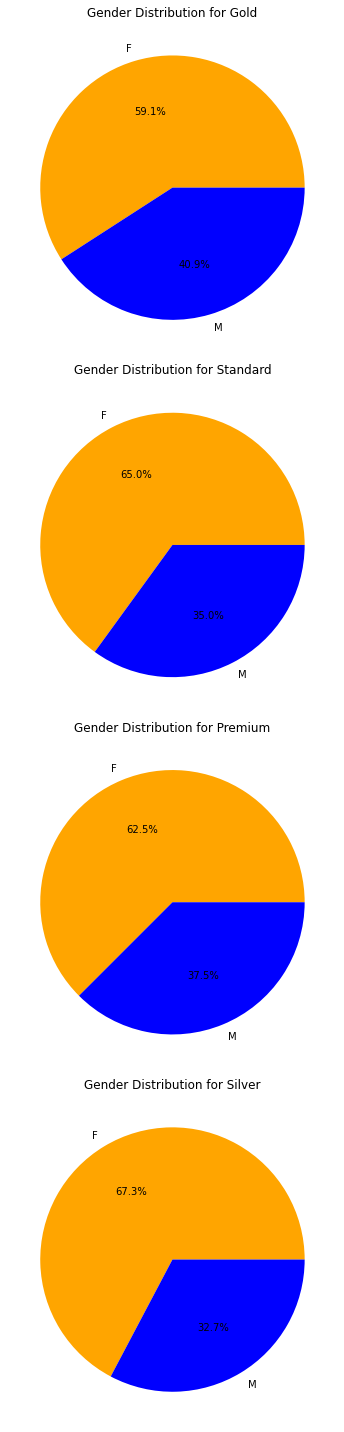

In [546]:
total_score_ranks =new_all_customer_demo['Total_Score_rank'].unique()
colors = {'M': 'blue', 'F': 'orange'}

fig, axs = plt.subplots(len(total_score_ranks), figsize=(15, 5*4))

for i, rank in enumerate(total_score_ranks):
    # Filter data for the current total score rank
    data = new_all_customer_demo[new_all_customer_demo['Total_Score_rank'] == rank]
    gender_counts = data['Gender'].value_counts()
    gender_counts.plot(kind='pie', ax=axs[i], autopct='%1.1f%%',
                       colors=[colors.get(x) for x in gender_counts.index])
    axs[i].set_title(f'Gender Distribution for {rank}')
    axs[i].set_ylabel('')  # Remove y-label for better visualization

# Plotting
plt.tight_layout()
plt.show()

In [552]:
demo_color=['lightsalmon','lightcoral','lemonchiffon','lightskyblue','lightpink']

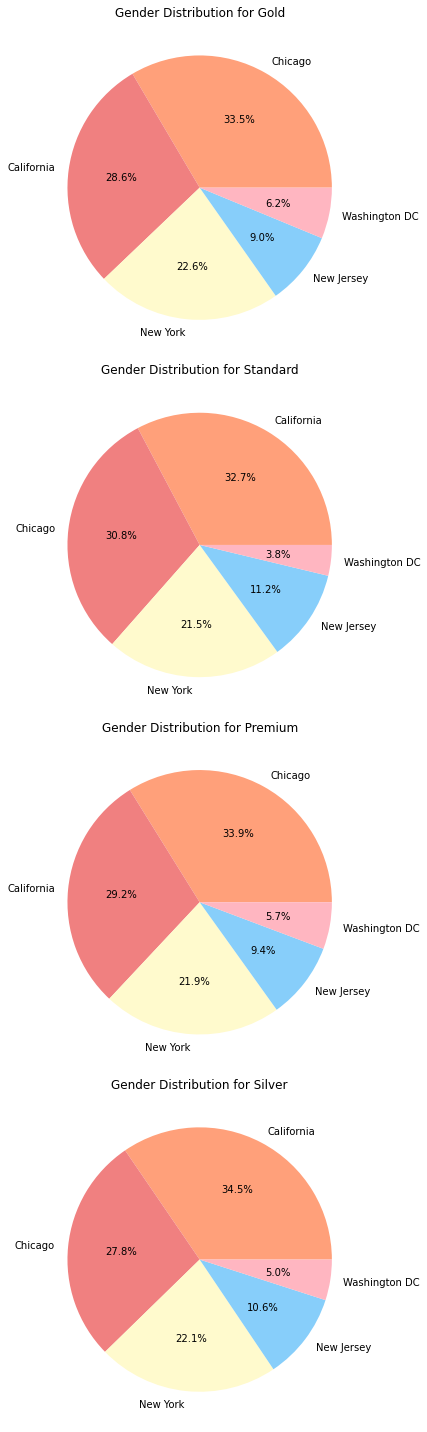

In [553]:
total_score_ranks =new_all_customer_demo['Total_Score_rank'].unique()
#location_counts = data['Location'].value_counts()

fig, axs = plt.subplots(len(total_score_ranks), figsize=(10, 5*4))

for i, rank in enumerate(total_score_ranks):
    # Filter data for the current total score rank
    data = new_all_customer_demo[new_all_customer_demo['Total_Score_rank'] == rank]
    location_counts = data['Location'].value_counts()
    location_counts.plot(kind='pie', ax=axs[i], autopct='%1.1f%%',
                       colors=demo_color)
    axs[i].set_title(f'Gender Distribution for {rank}')
    axs[i].set_ylabel('')  # Remove y-label for better visualization

# Plotting
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Mean Tenure Month in Different Customer Segementation')

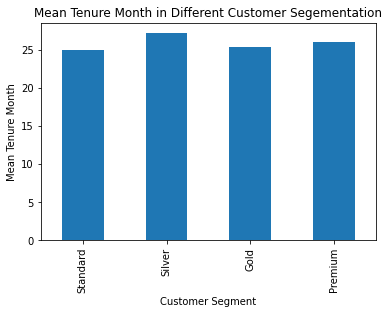

In [548]:
new_all_customer_demo.groupby('Total_Score_rank').apply(lambda x: x['Tenure_Months'].mean()).plot(kind='bar')
plt.ylabel('Mean Tenure Month')
plt.xlabel('Customer Segment')
plt.title('Mean Tenure Month in Different Customer Segementation')

## 【unfinished-Strategy2】Following the hypothesis of a normal distribution: 

In [480]:
import seaborn as sns

In [500]:
all_customer['Recency_Days']=all_customer['Recency'].dt.days
# Rename the 'Frequency' column to 'purchase_freq'
#all_customer.rename(columns={'Frequency': 'Purchase_Freq'}, inplace=True)

In [501]:
all_customer.columns

Index(['CustomerID', 'Recency', 'Frequncy', 'Monetary', 'Recency_rank',
       'Frequncy_rank', 'Monetary_rank', 'Total_Score', 'Total_Score_rank',
       'Recency_Days'],
      dtype='object')

In [502]:
all_customer.columns=['CustomerID', 'Recency', 'Purchase_Freq', 'Monetary', 'Recency_rank',
       'Frequncy_rank', 'Monetary_rank', 'Total_Score', 'Total_Score_rank',
       'Recency_Days']

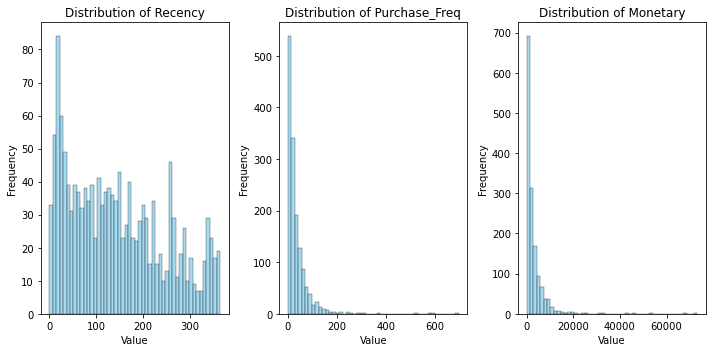

In [503]:
# Assuming 'df' is your DataFrame and 'column' is the column you want to plot
fig, axs= plt.subplots(1, 3, figsize=(10, 5))

#Recency
sns.histplot(data=all_customer, x='Recency_Days', bins=50, color='skyblue', 
             edgecolor='black', ax=axs[0])
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of Recency')

#Frequency
sns.histplot(data=all_customer, x='Purchase_Freq', bins=50, color='skyblue', 
             edgecolor='black', ax=axs[1])
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Purchase_Freq')

#Monetary
sns.histplot(data=all_customer, x='Monetary', bins=50, color='skyblue', 
             edgecolor='black', ax=axs[2])
axs[2].set_xlabel('Value')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Distribution of Monetary')

# Show the plot
plt.tight_layout()
plt.show()

## K-mean

/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-715-f268df325cbf>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-715-f268df325cbf>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

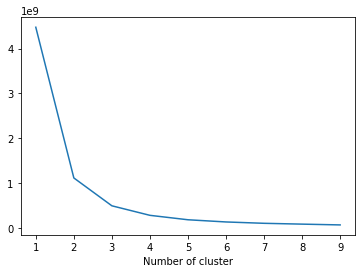

In [715]:
from sklearn.cluster import KMeans

sse={} # error
recency = rmf_data[['CustomerID','Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [716]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
recency['RecencyCluster'] = kmeans.fit_predict(recency[['Recency']])

/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [719]:
recency.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,287.0,303.641115,36.122462,252.0,268.5,299.0,337.50,364.0
1,478.0,34.713389,21.095159,0.0,18.0,31.0,52.75,76.0
2,394.0,117.812183,23.557309,78.0,96.0,118.0,137.00,158.0
3,309.0,199.563107,25.027259,159.0,176.0,200.0,221.00,251.0


In [708]:
rmf_data

,CustomerID,Recency,Frequency,Monetary,kmean_cluster,heuristic_segment,kmean_segment
0,12346,107,2,21.693,0,Standard,Standard
1,12347,59,60,13053.352,3,Premium,Gold
2,12348,73,23,1311.415,0,Gold,Standard
3,12350,17,17,1207.853,0,Gold,Standard
4,12356,107,36,1235.722,0,Gold,Standard
...,...,...,...,...,...,...,...
1463,18259,270,7,533.150,1,Standard,Silver
1464,18260,87,40,2132.738,1,Gold,Silver
1465,18269,194,8,97.997,1,Standard,Silver
1466,18277,69,1,298.000,1,Silver,Silver


In [709]:
rmf_data = all_customer[['CustomerID', 'Recency', 'Frequncy', 'Monetary']]
rmf_data.columns=['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [710]:
rmf_data.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,107,2,21.693
1,12347,59,60,13053.352
2,12348,73,23,1311.415
3,12350,17,17,1207.853
4,12356,107,36,1235.722


In [565]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [566]:
# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(rmf_data)

In [569]:
kmeans = KMeans(n_clusters=4, random_state=0)
rmf_data['kmean_segment'] = kmeans.fit_predict(scaled_features)

/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
<ipython-input-569-a8066b740670>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rmf_data['kmean_segment'] = kmeans.fit_predict(scaled_features)


In [571]:
rmf_data['heuristic_segment']= all_customer['Total_Score_rank']

<ipython-input-571-4d57ae06acb2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rmf_data['heuristic_segment']= all_customer['Total_Score_rank']


<AxesSubplot:xlabel='Recency', ylabel='kmean_segment'>

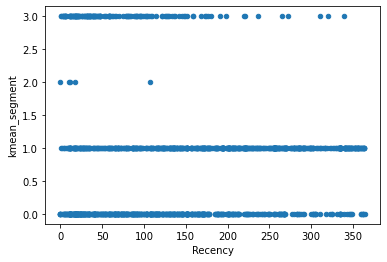

In [573]:
rmf_data[['Recency', 'kmean_segment']].plot(kind='scatter', x='Recency', y='kmean_segment')

In [582]:
rmf_data.head()

,CustomerID,Recency,Frequency,Monetary,kmean_cluster,heuristic_segment,kmean_segment
0,12346,107,2,21.693,0,Standard,Standard
1,12347,59,60,13053.352,3,Premium,Premium
2,12348,73,23,1311.415,0,Gold,Standard
3,12350,17,17,1207.853,0,Gold,Standard
4,12356,107,36,1235.722,0,Gold,Standard


In [597]:
# rmf_data.columns=['CustomerID', 'Recency', 'Frequency', 'Monetary', 'kmean_cluster',
#        'heuristic_segment'];
kmean_cluster_map = {0: 'Standard', 1: 'Silver', 2: 'Premium', 3: 'Gold'}
rmf_data['kmean_segment'] = rmf_data['kmean_cluster'].map(kmean_cluster_map)

<ipython-input-597-fa4230a622ba>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [598]:
kmean_cluster_map.values()

dict_values(['Standard', 'Silver', 'Premium', 'Gold'])

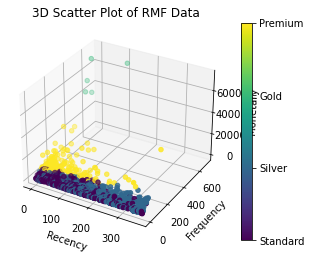

In [601]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a new figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(rmf_data['Recency'], 
                     rmf_data['Frequency'], 
                     rmf_data['Monetary'], 
                     c=rmf_data['kmean_cluster'], 
                     cmap='viridis')
color_bar = plt.colorbar(scatter)
color_bar.set_ticks(range(len(kmean_cluster_map)))
color_bar.set_ticklabels(['Standard', 'Silver', 'Gold','Premium'])

# Set labels and title
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Scatter Plot of RMF Data')

# Show the plot
plt.show()


In [603]:
import plotly.graph_objs as go

# Create a trace for the 3D scatter plot
trace = go.Scatter3d(
    x=rmf_data['Recency'],
    y=rmf_data['Frequency'],
    z=rmf_data['Monetary'],
    mode='markers',
    marker=dict(
        size=8,
        color=rmf_data['kmean_cluster'],  # Color by kmean_segment
        colorscale='Viridis',             # Use Viridis colormap
        opacity=0.8
    )
)

# Create layout for the plot
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='Recency'),
        yaxis=dict(title='Frequency'),
        zaxis=dict(title='Monetary')
    ),
    title='Interactive 3D Scatter Plot of RMF Data'
)

# Combine trace and layout to create a figure
fig = go.Figure(data=[trace], layout=layout)

# Display the interactive plot
fig.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.data import iris_data
from mlxtend.plotting import plot_decision_regions

# Initializing Classifiers
clf1 = LogisticRegression(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
clf3 = SVC(random_state=0, probability=True)
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3],
                              weights=[2, 1, 1], voting='soft')

# Loading some example data
X, y = iris_data()
X = X[:,[0, 2]]

# Plotting Decision Regions

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))

labels = ['Logistic Regression',
          'Random Forest',
          'RBF kernel SVM',
          'Ensemble']

for clf, lab, grd in zip([clf1, clf2, clf3, eclf],
                         labels,
                         itertools.product([0, 1],
                         repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y,
                                clf=clf, legend=2)
    plt.title(lab)

plt.show()

# Customer Lifetime Value

Predicting Customer Lifetime Value (Low Value/Medium Value/High Value): <br>
1. Define dependent variable with categories low value, medium value, high value
using customer revenue.
2. Perform Classification model
Cross-Selling (Which products are selling together)
3. [Additional]exploratory analysis & market basket analysis to understand which of items can be bundled together.

## LTV

In [694]:
LTV_table= all_customer_discount_and_price_tax_table[['CustomerID','Product_Category',
                                                     'Quantity', 'Revenue','Invoice_Value']]
LTV_table= pd.merge(LTV_table, all_customer, how='left', on='CustomerID')

In [695]:
LTV_table['Revenue_segment'] = pd.cut(LTV_table['Revenue'], bins=[0, 1000, 5000, float('inf')],
                              labels=['Low Value', 'Medium Value', 'High Value'])

In [696]:
LTV_table.Revenue_segment.value_counts()

Low Value       52808
Medium Value      111
High Value          5
Name: Revenue_segment, dtype: int64

In [699]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

In [700]:
# Select features and target variable
X = LTV_table[['Recency', 'Frequncy', 'Monetary']]
Y = LTV_table['Revenue_segment']

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [701]:
model = LogisticRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [702]:
accuracy = accuracy_score(Y_test, Y_pred)
classification_report = classification_report(Y_test, Y_pred)

/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [703]:
print(f'Accuracy: {accuracy}')
print(classification_report)

Accuracy: 0.9982050070854983
              precision    recall  f1-score   support

  High Value       0.00      0.00      0.00         2
   Low Value       1.00      1.00      1.00     10569
Medium Value       0.00      0.00      0.00        14

    accuracy                           1.00     10585
   macro avg       0.33      0.33      0.33     10585
weighted avg       1.00      1.00      1.00     10585



In [705]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



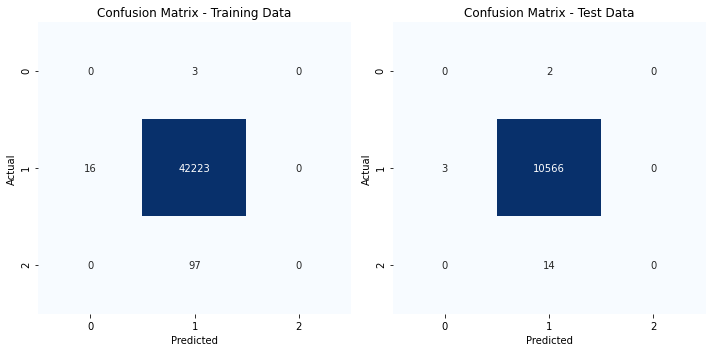

In [707]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, Y_train)

# Predict target variable for both training and test datasets
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# Compute confusion matrices
train_cm = confusion_matrix(Y_train, Y_train_pred)
test_cm = confusion_matrix(Y_test, Y_test_pred)

# Plot confusion matrix for training data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Training Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Plot confusion matrix for test data
plt.subplot(1, 2, 2)
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Test Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()


(0.0, 500.0)

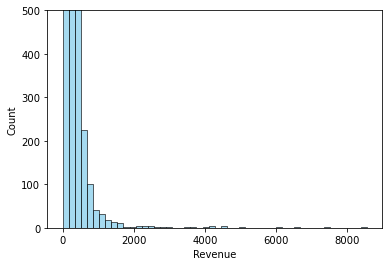

In [624]:
sns.histplot(data=LTV_atable, x='Revenue', bins=50, color='skyblue', 
             edgecolor='black')
plt.ylim(0, 500)

In [609]:
LTV_table.Revenue.mean()

82.41994473276439

## Bundle- Cross Selling

reference: https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/

In [724]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [738]:
#Every Transaction contains how many items (by category)
#unstack into dummy coding (one-hot dataframe)
quantity_dummycoding = all_customer_discount_and_price_tax_table.groupby(
    ['Transaction_ID', 'Product_Category'])['Quantity'].sum().unstack().fillna(0)
#quantity_dummycoding.head()
quantity_dummycoding[quantity_dummycoding > 0] = 1

/Users/christina/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [739]:
total_length= len(quantity_dummycoding)

/Users/christina/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [747]:
threshold= len(quantity_dummycoding[quantity_dummycoding.sum(axis=1)>1])/len(quantity_dummycoding)
#0.2229759387095487
frequent_itemsets = apriori(quantity_dummycoding, 
                            min_support=threshold, use_colnames=True)

/Users/christina/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/christina/opt/anaconda3/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



In [727]:
#frequent_itemsets

/Users/christina/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [728]:
association_rules_df = association_rules(frequent_itemsets, 
                                         metric='lift', min_threshold=0.5)
frequent_itemsets['itemsets'].apply(lambda x: list(x))

/Users/christina/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0                [Apparel]
1                   [Bags]
2              [Drinkware]
3              [Lifestyle]
4                   [Nest]
5               [Nest-USA]
6                 [Office]
7     [Drinkware, Apparel]
8     [Lifestyle, Apparel]
9        [Office, Apparel]
10     [Office, Drinkware]
11     [Office, Lifestyle]
Name: itemsets, dtype: object

In [729]:
association_rules_df

/Users/christina/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Drinkware),(Apparel),0.100714,0.324369,0.045010,0.446910,1.377784,0.012342,1.221557,0.304905
1,(Apparel),(Drinkware),0.324369,0.100714,0.045010,0.138762,1.377784,0.012342,1.044179,0.405838
2,(Lifestyle),(Apparel),0.068313,0.324369,0.033079,0.484229,1.492836,0.010921,1.309945,0.354340
3,(Apparel),(Lifestyle),0.324369,0.068313,0.033079,0.101981,1.492836,0.010921,1.037491,0.488630
4,(Office),(Apparel),0.140697,0.324369,0.062128,0.441577,1.361343,0.016491,1.209892,0.308891
5,(Apparel),(Office),0.324369,0.140697,0.062128,0.191536,1.361343,0.016491,1.062884,0.392864
6,(Office),(Drinkware),0.140697,0.100714,0.046287,0.328985,3.266516,0.032117,1.340187,0.807472
7,(Drinkware),(Office),0.100714,0.140697,0.046287,0.459588,3.266516,0.032117,1.590089,0.771572
8,(Office),(Lifestyle),0.140697,0.068313,0.035114,0.249575,3.653381,0.025503,1.241545,0.845197
9,(Lifestyle),(Office),0.068313,0.140697,0.035114,0.514019,3.653381,0.025503,1.768182,0.779533


# Next Purchase Prediction

Predicting Next Purchase Day (How soon each customer can visit the store (0-30 days, 30-60
days, 60-90 days, 90+ days)
<br>
1. For this, we need create dependent variable at customer level (average days per one transaction for only repeat customers and divide into groups 0-30 days, 30-60 days, 60-90 days and 90+ days) 
2. then build classification model to predict next purchase of given customer.

In [201]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [117]:
#Feature Selection
Product_vector = discount_and_price_table.groupby(
    ['CustomerID', 'Transaction_Date','Product_Category'])['Quantity'].sum().unstack().fillna(0)

Coupon_vector=discount_and_price_table.groupby(
    ['CustomerID', 'Transaction_Date','Coupon_Status'])['Discount_pct'].sum().unstack().fillna(0)

Delivery_scalar=discount_and_price_table.groupby(
    ['CustomerID', 'Transaction_Date'])['Delivery_Charges'].sum()

In [120]:
X = pd.concat([Product_vector, Coupon_vector, Delivery_scalar], axis=1)

In [225]:
pv =Prodcut_vector.reset_index()
x= X.reset_index()
x['Time_Interval']=pv.groupby('CustomerID')['Transaction_Date'].diff().dt.days
x['To_Next_Purchase_Date']=x['Time_Interval'].shift(-1)
x['Interval_Category']= pd.cut(x['To_Next_Purchase_Date'], 
                               bins=[-1, 30, 60, 90, float('inf')], 
                               labels=['0-30 days', '31-60 days', '61-90 days', '90+ days'])
x['Num_Category']= pd.cut(x['To_Next_Purchase_Date'], 
                               bins=[-1, 30, 60, 90, float('inf')], labels=False)
#remove those who have only purchased once
x_data= x.dropna(axis=0) 

In [226]:
x_data.head()

,CustomerID,Transaction_Date,Accessories,Android,Apparel,Backpacks,Bags,Bottles,Drinkware,Fun,...,Office,Waze,Clicked,Not Used,Used,Delivery_Charges,Time_Interval,To_Next_Purchase_Date,Interval_Category,Num_Category
2,12347,2019-11-01,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,60.0,0.0,20.0,53.70,222.0,1.0,0-30 days,0.0
15,12383,2019-07-14,0.0,0.0,10.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,110.0,20.0,70.0,120.99,1.0,41.0,31-60 days,1.0
16,12383,2019-08-24,0.0,0.0,22.0,2.0,2.0,0.0,3.0,0.0,...,6.0,3.0,320.0,100.0,180.0,306.91,41.0,30.0,0-30 days,0.0
24,12395,2019-06-28,0.0,0.0,17.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,330.0,60.0,180.0,114.00,139.0,22.0,0-30 days,0.0
33,12415,2019-07-27,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,10.0,0.0,0.0,6.00,1.0,17.0,0-30 days,0.0


In [228]:
x_data.set_index('CustomerID',inplace=True)

In [229]:
features=x_data.iloc[:,1:-3]
depedent=x_data.iloc[:,-1]

In [227]:
# features=x_data.iloc[:,:-3]
# depedent=x_data.iloc[:,-1]

In [202]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.data import iris_data
from mlxtend.plotting import plot_decision_regions

In [232]:
X_train, X_test, y_train, y_test = train_test_split(features, depedent, test_size=0.2, random_state=42)

In [242]:
X_train_np = X_train.to_numpy()
X_test_np= X_test.to_numpy()

y_train_np = y_train.to_numpy()
y_test_np= y_test.to_numpy()

y_train_np_int = y_train_np.astype(np.int_)
y_test_np_int= y_test_np.astype(np.int_)

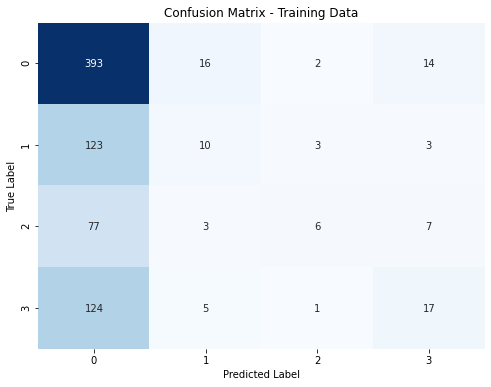

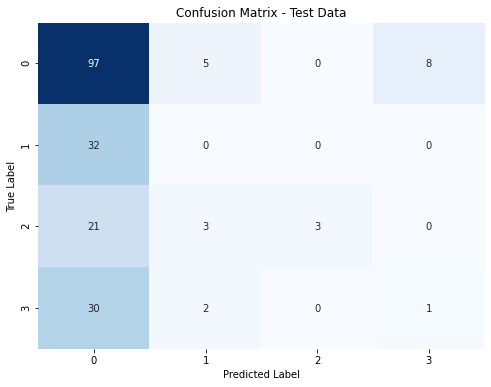

In [244]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix for training data
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [243]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Assuming clf is your classifier and X_test_np, y_test_np_int are your test data
# Predictions on the training data
y_train_pred = clf.predict(X_train_np)
train_accuracy = accuracy_score(y_train_np_int, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Confusion matrix for training data
train_conf_matrix = confusion_matrix(y_train_np_int, y_train_pred)
print("Training Confusion Matrix:")
print(train_conf_matrix)

# Predictions on the test data
y_test_pred = clf.predict(X_test_np)
test_accuracy = accuracy_score(y_test_np_int, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Confusion matrix for test data
test_conf_matrix = confusion_matrix(y_test_np_int, y_test_pred)
print("Test Confusion Matrix:")
print(test_conf_matrix)


Training Accuracy: 0.5298507462686567
Training Confusion Matrix:
[[393  16   2  14]
 [123  10   3   3]
 [ 77   3   6   7]
 [124   5   1  17]]
Test Accuracy: 0.5
Test Confusion Matrix:
[[97  5  0  8]
 [32  0  0  0]
 [21  3  3  0]
 [30  2  0  1]]


疑問：

In [159]:
discount_and_price_table.iloc[38120:38126] #為什麼不同人可以有同樣的 Transaction_ID 



,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Coupon_Code,Discount_pct
38120,12346,38223,2019-09-15,GGOEAAAJ080816,Android Men's Engineer Short Sleeve Tee Charcoal,Apparel,1,19.99,75.0,Used,Sep,SALE30,30.0
38121,12748,38223,2019-09-15,GGOEAAFB035917,Android Men's Zip Hoodie,Apparel,1,39.19,75.0,Used,Sep,SALE30,30.0
38122,12748,38223,2019-09-15,GGOEGAAL010617,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,1,16.99,75.0,Used,Sep,SALE30,30.0
38123,12748,38223,2019-09-15,GGOEGOAQ012899,Ballpoint LED Light Pen,Office,1,2.50,75.0,Clicked,Sep,OFF30,30.0
38124,12748,38223,2019-09-15,GGOEGOAQ020099,Four Color Retractable Pen,Office,1,2.99,75.0,Not Used,Sep,OFF30,30.0
38125,12346,38223,2019-09-15,GGOEGOAR013099,Google Stylus Pen w/ LED Light,Office,2,5.50,75.0,Used,Sep,OFF30,30.0


# cohort analysis

Perform cohort analysis by defining below cohorts <br> 
1. Customers who started in each month and understand their behavior
2. Which Month cohort has maximum retention?